In [2]:
import scanpy as sc
import anndata as ann
import loompy as lo
import numpy as np 
import glob
import seaborn as sb
import pandas as pd
import scrublet as scr
import pickle

sc.settings.verbosity = 3

from matplotlib import rcParams
import matplotlib.pyplot as plt

import sys  
sys.path.insert(0, '/lustre/groups/ml01/code/karin.hrovatin/mm_pancreas_atlas_rep/code/')
import helper as h
from constants import SAVE

#R interface
import rpy2.rinterface_lib.callbacks
import logging
from rpy2.robjects import pandas2ri
import anndata2ri

rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

In [3]:
%%R
library(scran)
library(RColorBrewer)
library(DropletUtils)
library(BiocParallel)

In [4]:
# Path for saving results - last shared folder by all datasets
shared_folder='/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/GSE142465/'
#Path for loading individual samples
path_data='/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/GSE142465/scanpy_AnnData/SRR107515*/'
#Unique ID2 for reading/writing h5ad files with helper function
UID2='spikein_drug_pp'

## Load data (filtered)

In [5]:
# Load metadata for the project
metadata=pd.read_excel('/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/scRNA-seq_pancreas_metadata.xlsx',
             sheet_name='spikein_drug')

In [6]:
# Find samples used for reference
samples=metadata
print('Selected samples:')
print(samples)

Selected samples:
    sample_name          metadata  replicate tissue strain   design  \
0   SRR10751502      mIslets_I_A1          1  islet  129SV    A1_r1   
1   SRR10751503     mIslets_I_A10          1  islet  129SV   A10_r1   
2   SRR10751504    mIslets_I_DMSO          1  islet  129SV  DMSO_r1   
3   SRR10751505    mIslets_I_FoxO          1  islet  129SV  FOXO_r1   
4   SRR10751506    mIslets_I_GABA          1  islet  129SV  GABA_r1   
5   SRR10751507     mIslets_II_A1          2  islet  129SV    A1_r2   
6   SRR10751508    mIslets_II_A10          2  islet  129SV   A10_r2   
7   SRR10751509   mIslets_II_DMSO          2  islet  129SV  DMSO_r2   
8   SRR10751510   mIslets_II_FoxO          2  islet  129SV  FOXO_r2   
9   SRR10751511   mIslets_II_GABA          2  islet  129SV  GABA_r2   
10  SRR10751512    mIslets_III_A1          3  islet  129SV    A1_r3   
11  SRR10751513   mIslets_III_A10          3  islet  129SV   A10_r3   
12  SRR10751514  mIslets_III_DMSO          3  islet  129SV 

In [6]:
# List all files
file_name='filtered_feature_bc_matrix.h5ad'
files=glob.glob(path_data+file_name)
# Find which parts of file paths differ between files to later use them as file id
diff_path_idx=[]
for position in range(len(path_data.split('/'))):
    values=set([file.split('/')[position] for file in files])
    if len(values)>1:
        diff_path_idx.append(position)

In [7]:
# Subset to files used for reference
files_subset=[]
for file in files:
    sample='_'.join([file.split('/')[i] for i in diff_path_idx])
    if any(sample_name in sample for sample_name in samples.sample_name.values):
        files_subset.append(file)
print('Reference sample files:')
print(files_subset)

Reference sample files:
['/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/GSE142465/scanpy_AnnData/SRR10751509/filtered_feature_bc_matrix.h5ad', '/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/GSE142465/scanpy_AnnData/SRR10751503/filtered_feature_bc_matrix.h5ad', '/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/GSE142465/scanpy_AnnData/SRR10751510/filtered_feature_bc_matrix.h5ad', '/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/GSE142465/scanpy_AnnData/SRR10751504/filtered_feature_bc_matrix.h5ad', '/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/GSE142465/scanpy_AnnData/SRR10751513/filtered_feature_bc_matrix.h5ad', '/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/GSE142465/scanpy_AnnData/SRR10751514/filtered_feature_bc_matrix.h5ad', '/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/GSE142465/scanpy_AnnData/SRR10751507/filtered_feature_bc_matrix.h5ad', '/lustre/groups/

In [8]:
# Load files and extract parts of file path that identifies the file, compared to other loaded files
adatas=[]
file_diffs=[]
for file in files_subset:
    print('Reading file',file)
    #adatas.append(sc.read_h5ad(file))
    adatas.append(h.open_h5ad(file=file,unique_id2=UID2))
    file_diffs.append('_'.join([file.split('/')[i] for i in diff_path_idx]))
    
adata = ann.AnnData.concatenate( *adatas,  batch_key = 'file', batch_categories = file_diffs).copy()    

Reading file /lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/GSE142465/scanpy_AnnData/SRR10751509/filtered_feature_bc_matrix.h5ad
Reading file /lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/GSE142465/scanpy_AnnData/SRR10751503/filtered_feature_bc_matrix.h5ad
Reading file /lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/GSE142465/scanpy_AnnData/SRR10751510/filtered_feature_bc_matrix.h5ad
Reading file /lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/GSE142465/scanpy_AnnData/SRR10751504/filtered_feature_bc_matrix.h5ad
Reading file /lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/GSE142465/scanpy_AnnData/SRR10751513/filtered_feature_bc_matrix.h5ad
Reading file /lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/GSE142465/scanpy_AnnData/SRR10751514/filtered_feature_bc_matrix.h5ad
Reading file /lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/GSE142465/scanpy_AnnData/SRR10751507/fil

In [10]:
# Sample names
file_diffs

['SRR10751509',
 'SRR10751503',
 'SRR10751510',
 'SRR10751504',
 'SRR10751513',
 'SRR10751514',
 'SRR10751507',
 'SRR10751505',
 'SRR10751516',
 'SRR10751511',
 'SRR10751502',
 'SRR10751508',
 'SRR10751506',
 'SRR10751515',
 'SRR10751512']

In [11]:
adata

AnnData object with n_obs × n_vars = 41249 × 31257
    obs: 'file'

In [12]:
# Add file annotation if single sample is present so that below code works
if len(file_diffs)==1:
    adata.obs['file']=file_diffs[0]

## Empty droplets and ambient gene expression

### Check that empty droplets were removed

N counts for cells that passed CellRanger filtering

In [13]:
# Visually check if empty cells are present
adata.obs['n_counts'] = adata.X.sum(axis = 1)

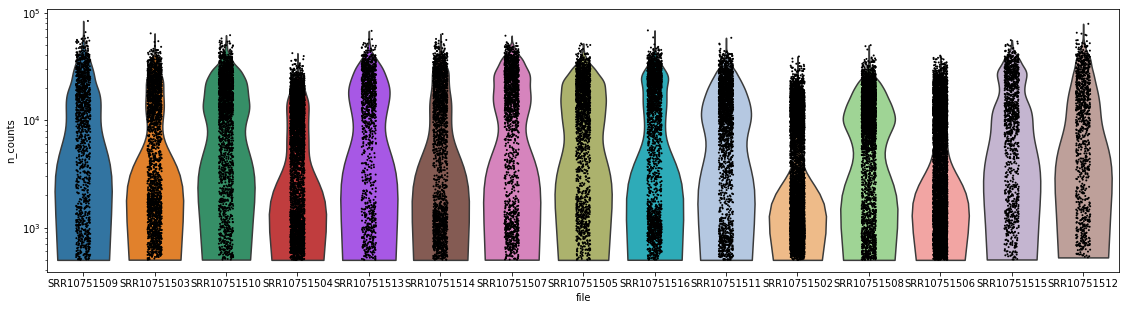

In [37]:
rcParams['figure.figsize']= (15,5)
t1 = sc.pl.violin(adata, 'n_counts',
                  groupby='file',
                  size=2, log=True, cut=0)

In [7]:
# Load raw data
# List all files
file_name='raw_feature_bc_matrix.h5ad'
files=glob.glob(path_data+file_name)
# Find which parts of file paths differ between files to later use them as file id
diff_path_idx=[]
for position in range(len(path_data.split('/'))):
    values=set([file.split('/')[position] for file in files])
    if len(values)>1:
        diff_path_idx.append(position)

In [8]:
# Subset to files used for reference
files_subset=[]
for file in files:
    sample='_'.join([file.split('/')[i] for i in diff_path_idx])
    if any(sample_name in sample for sample_name in samples.sample_name.values):
        files_subset.append(file)
print('Reference sample files:')
print(files_subset)

Reference sample files:
['/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/GSE142465/scanpy_AnnData/SRR10751509/raw_feature_bc_matrix.h5ad', '/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/GSE142465/scanpy_AnnData/SRR10751503/raw_feature_bc_matrix.h5ad', '/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/GSE142465/scanpy_AnnData/SRR10751510/raw_feature_bc_matrix.h5ad', '/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/GSE142465/scanpy_AnnData/SRR10751504/raw_feature_bc_matrix.h5ad', '/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/GSE142465/scanpy_AnnData/SRR10751513/raw_feature_bc_matrix.h5ad', '/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/GSE142465/scanpy_AnnData/SRR10751514/raw_feature_bc_matrix.h5ad', '/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/GSE142465/scanpy_AnnData/SRR10751507/raw_feature_bc_matrix.h5ad', '/lustre/groups/ml01/workspace/karin.hrovatin/data/

In [9]:
# Load files and extract parts of file path that identifies the file, compared to other loaded files
adatas_raw=[]
file_diffs=[]
for file in files_subset:
    print('Reading file',file)
    #adatas_raw.append(sc.read_h5ad(file))
    adatas_raw.append(h.open_h5ad(file=file,unique_id2=UID2))
    file_diffs.append('_'.join([file.split('/')[i] for i in diff_path_idx]))
    
adata_raw = ann.AnnData.concatenate( *adatas_raw,  batch_key = 'file', batch_categories = file_diffs).copy()    

Reading file /lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/GSE142465/scanpy_AnnData/SRR10751509/raw_feature_bc_matrix.h5ad
Reading file /lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/GSE142465/scanpy_AnnData/SRR10751503/raw_feature_bc_matrix.h5ad
Reading file /lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/GSE142465/scanpy_AnnData/SRR10751510/raw_feature_bc_matrix.h5ad
Reading file /lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/GSE142465/scanpy_AnnData/SRR10751504/raw_feature_bc_matrix.h5ad
Reading file /lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/GSE142465/scanpy_AnnData/SRR10751513/raw_feature_bc_matrix.h5ad
Reading file /lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/GSE142465/scanpy_AnnData/SRR10751514/raw_feature_bc_matrix.h5ad
Reading file /lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/GSE142465/scanpy_AnnData/SRR10751507/raw_feature_bc_matrix.h5ad
Readin

In [10]:
adata_raw

AnnData object with n_obs × n_vars = 11059200 × 31257
    obs: 'file'

In [11]:
# Add file annotation if single sample is present so that below code works
if len(file_diffs)==1:
    adata_raw.obs['file']=file_diffs[0]

In [12]:
adata_raw.obs['n_counts'] = adata_raw.X.sum(1)

In [24]:
# Find drops removed by CellRanger
filtered_drops=~adata_raw.obs.index.isin(adata.obs.index)
print('N drops filtered out as empty:',filtered_drops.sum(),
      'out of all drops:',adata_raw.shape[0],'-> remaining:',adata.shape[0])

N drops filtered out as empty: 11017951 out of all drops: 11059200 -> remaining: 41249


Distribution of N counts of drops that were removed by CellRanger

Trying to set attribute `.uns` of view, copying.


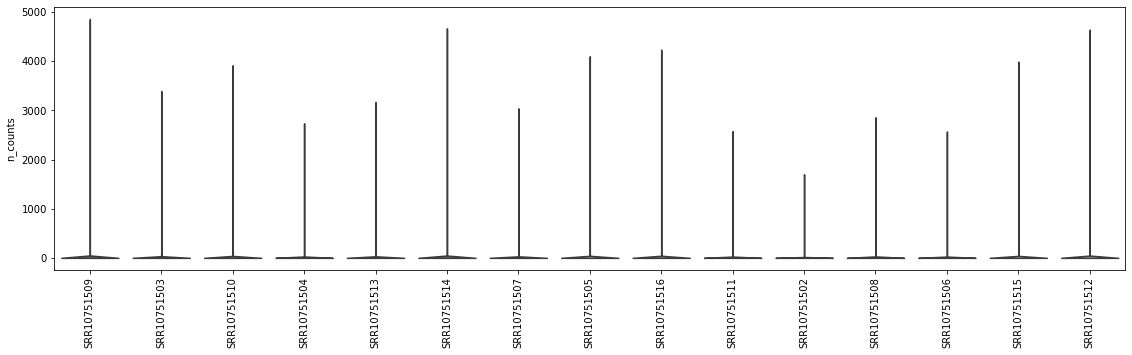

In [25]:
# Plot n_counts of drops that were removed by CellRanger
rcParams['figure.figsize']= (15,5)
sc.pl.violin(adata_raw[filtered_drops], ['n_counts'], groupby='file', size=1, log=False,rotation=90,stripplot=False)

In [26]:
#print('N cells per non-filtered sample')
#adata_raw.obs['file'].value_counts()

In [13]:
#Remove empty genes and cells
sc.pp.filter_cells(adata_raw, min_counts=1)
sc.pp.filter_genes(adata_raw, min_cells=1)

filtered out 6129589 cells that have less than 1 counts
filtered out 7450 genes that are detected in less than 1 cells


In [14]:
adata_raw

AnnData object with n_obs × n_vars = 4929611 × 23807
    obs: 'file', 'n_counts'
    var: 'n_cells'

Cell N counts sorted by cell N counts rank without all 0 cells. 

In [34]:
from cycler import cycler

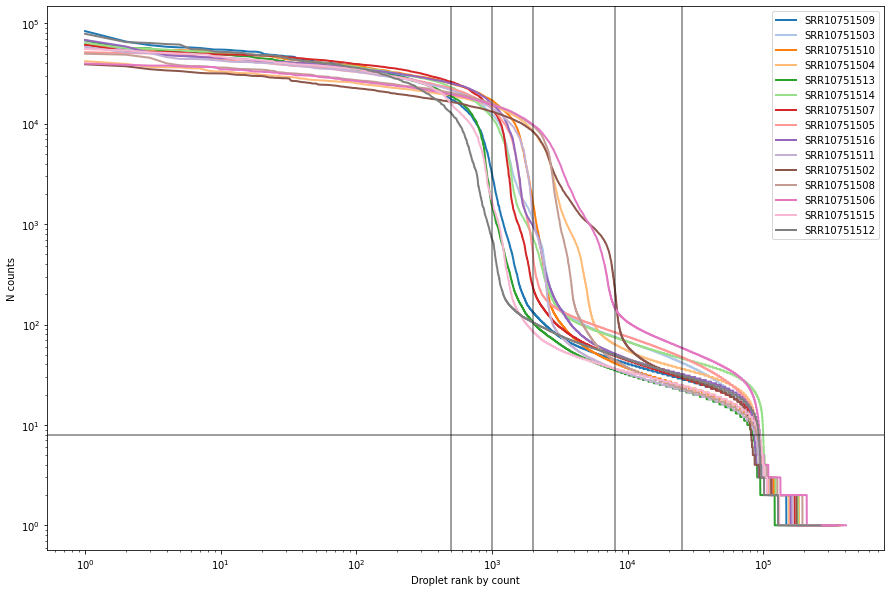

In [43]:
# For each file plot N count vs cell rank by count with log axes
rcParams['figure.figsize']= (15,10)
fig, ax=plt.subplots()
ax.set_prop_cycle(cycler(color=plt.cm.tab20.colors))
for file in adata_raw.obs.file.unique():
    adata_raw_sub=adata_raw[adata_raw.obs.file==file,:].copy()
    plt.plot(list(range(1,adata_raw_sub.shape[0]+1)),adata_raw_sub.obs.n_counts.sort_values(ascending=False),
            label=file,lw=2)
del adata_raw_sub
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Droplet rank by count')
plt.ylabel('N counts')
ax.axvline(500,c='k',alpha=0.5)
ax.axvline(1000,c='k',alpha=0.5)
ax.axvline(2000,c='k',alpha=0.5)
ax.axvline(25000,c='k',alpha=0.5)
ax.axvline(8000,c='k',alpha=0.5)
ax.axhline(8,c='k',alpha=0.5)

### Compute ambient genes

Compute ambient genes with emptyDrops and based on mean expression in low count droplets across all samples.

In [29]:
# Prepare data for emptyDrops
sparse_mat = adata_raw.X.T
genes = adata_raw.var_names
barcodes = adata_raw.obs_names

In [30]:
%%R -i sparse_mat -i genes -i barcodes -o ambient_scores
# Run emptyDrops and output scores per gene
sce <- SingleCellExperiment(assays = list(counts = sparse_mat), colData=barcodes)
rownames(sce) <- genes 
ambient <- emptyDrops(counts(sce),BPPARAM=MulticoreParam(workers = 16))
#is_cell <- ambient$FDR <= 0.05
#threshold_ambient <- 0.005
#ambient_genes <- names(ambient@metadata$ambient[ambient@metadata$ambient> threshold_ambient,])
ambient_scores <- as.data.frame(ambient@metadata$ambient)
#barcodes_filtered <- barcodes[which(is_cell)]

emptyDrops top ambient genes with scores.

In [31]:
ambient_scores.columns=['ambient_score']
ambient_scores.sort_values('ambient_score',ascending=False).query('ambient_score>=0.005')

ambient_score
Ins2          0.195938
Ins1          0.059023
Iapp          0.042991
Gcg           0.025384
Ppy           0.024431
mt-Co3        0.016105
mt-Atp6       0.012047
Malat1        0.010236
Pyy           0.010208
mt-Co1        0.009447
mt-Cytb       0.007561
mt-Co2        0.007288
mt-Nd1        0.005695
Sst           0.005541
Igkc          0.005460

Genes with highest mean expression in empty droplets (n_counts < 100, similar to emptyDrops).

In [15]:
ambient_vars=['mean_ambient_n_counts']
adata_raw.var['mean_ambient_n_counts']=adata_raw[adata_raw.obs['n_counts']<100].X.mean(0).A1
adata_raw.var['mean_ambient_n_counts'].sort_values(ascending=False)[:20]

index
Ins2       1.611649
Ins1       0.487629
Iapp       0.355473
Gcg        0.209825
Ppy        0.201939
mt-Co3     0.132799
mt-Atp6    0.099209
Malat1     0.084159
Pyy        0.083956
mt-Co1     0.077639
mt-Cytb    0.062010
mt-Co2     0.059765
mt-Nd1     0.046711
Sst        0.045449
Igkc       0.044776
Ftl1       0.038982
mt-Nd4     0.035154
Rpl41      0.030877
Rpl13      0.030100
Eef1a1     0.026992
Name: mean_ambient_n_counts, dtype: float32

#C: The two gene lists are very similar for top genes.

Compute ambient genes for each sample based on mean expression in empty droplets.

In [16]:
# Mean empty expression in individual samples
#for file in adata_raw.obs.file.cat.categories:
for file in adata_raw.obs.file.unique():
    adata_raw.var['mean_ambient_n_counts_' + file] = adata_raw[(adata_raw.obs.file == file) & (adata_raw.obs['n_counts']<100)
                                                  ].X.mean(0).A1
    ambient_vars.append('mean_ambient_n_counts_' + file)
    
# Top genes in individual samples    
ambient_genes = set()
#for file in adata_raw.obs.file.cat.categories:
for file in adata_raw.obs.file.unique():
    ambient_file = list(adata_raw.var['mean_ambient_n_counts_' + file][np.flip(np.argsort(adata_raw.var['mean_ambient_n_counts_' + file]))].index)
    ambient_genes.update(ambient_file)

Mean ambient expression in individual samples divided by total mean ambient expression of individual samples. Ordered by combined smples, including top 20 ambient genes from each comparison.

In [17]:
# Normalise ambient
ambient_df=adata_raw.var[ambient_vars]
ambient_df=ambient_df.loc[ambient_genes,ambient_vars]/ambient_df.sum(axis=0)

<AxesSubplot:ylabel='index'>

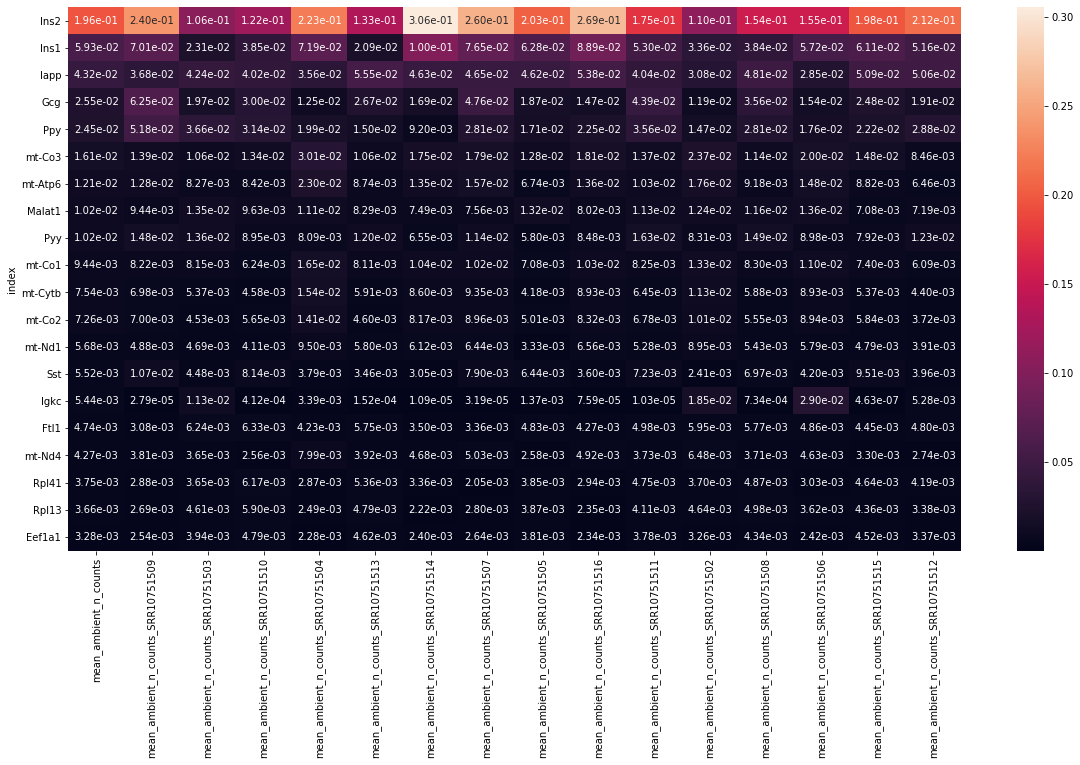

In [27]:
# Display ambient genes across samples
rcParams['figure.figsize']= (20,10)
sb.heatmap(ambient_df.sort_values('mean_ambient_n_counts',ascending=False).iloc[:20,:],annot=True,fmt='.2e')

In [28]:
# Save ambient DF for top N genes
if SAVE:
    ambient_df.to_csv(shared_folder+"ambient_genes_topN_scores.tsv",sep='\t')

In [45]:
# Save genes with scaled mean ambient expression at least > 0.005 in any sample - 
# use the same genes for each sample so that further prrocessing (cell type annotation, embedding) can be done jointly
# !!! Check on heatmap that all such genes were included in the filtered 20 genes
ambient_genes_selection=list(ambient_df[(ambient_df>0.005).any(axis=1)].index)

print('Selected ambient genes:',ambient_genes_selection)
if SAVE:
    pickle.dump( ambient_genes_selection, open( shared_folder+"ambient_genes_selection.pkl", "wb" ) )

Selected ambient genes: ['Ftl1', 'mt-Nd4', 'mt-Co1', 'Rpl41', 'Ighm', 'mt-Co3', 'Rpl13', 'mt-Co2', 'Ins1', 'mt-Cytb', 'Fth1', 'Gcg', 'Malat1', 'Sst', 'Ins2', 'Pyy', 'Iapp', 'Igkc', 'Ppy', 'mt-Nd1', 'mt-Atp6']


#### Distances between samples based on ambient gene scores

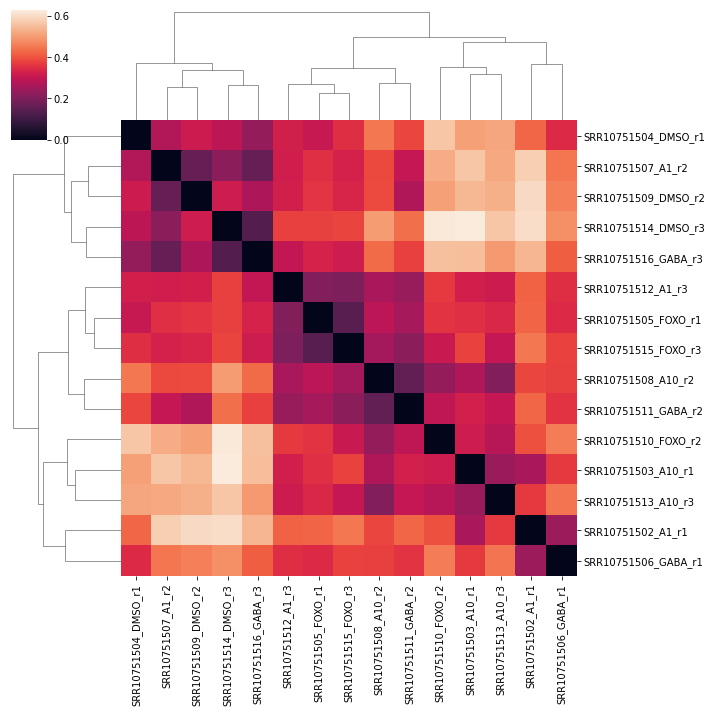

In [53]:
# Summed absolute distances between ambient scores of genes for each pair of samples
columns=[col for col in ambient_df.columns if col!='mean_ambient_n_counts']
col_names=[file+'_'+design for file,design in zip(metadata.sample_name,metadata.design)]
ambient_dist=pd.DataFrame(index=col_names,columns=col_names)
for idx1,col1 in enumerate(columns[:-1]):
    for idx2,col2 in enumerate(columns[idx1+1:]):
        diff=abs(ambient_df[col1]-ambient_df[col2]).sum()
        col_name1=col1.replace('mean_ambient_n_counts_','')
        col_name1=col_name1+'_'+metadata.query('sample_name==@col_name1')['design'].values[0]
        col_name2=col2.replace('mean_ambient_n_counts_','')
        col_name2=col_name2+'_'+metadata.query('sample_name==@col_name2')['design'].values[0]
        ambient_dist.at[col_name1,col_name2]=diff
        ambient_dist.at[col_name2,col_name1]=diff
ambient_dist.fillna(0,inplace=True)
sb.clustermap(ambient_dist)

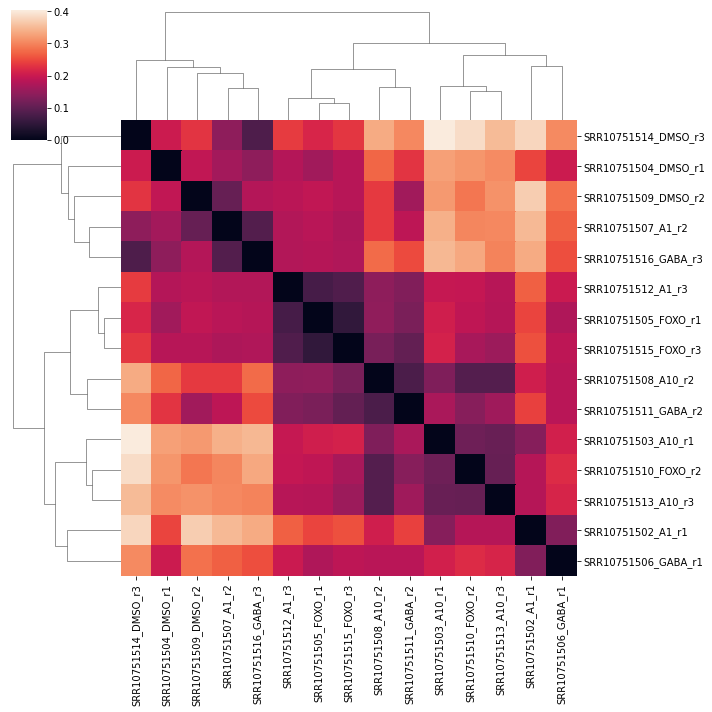

In [56]:
# Summed absolute distances between top (based on avg) ambient genes ambient scores for each pair of samples
ambient_df=ambient_df.sort_values('mean_ambient_n_counts',ascending=False)
columns=[col for col in ambient_df.columns if col!='mean_ambient_n_counts']
col_names=[file+'_'+design for file,design in zip(metadata.sample_name,metadata.design)]
ambient_dist=pd.DataFrame(index=col_names,columns=col_names)
for idx1,col1 in enumerate(columns[:-1]):
    for idx2,col2 in enumerate(columns[idx1+1:]):
        diff=abs(ambient_df.iloc[:50,:][col1]-ambient_df.iloc[:50,:][col2]).sum()
        col_name1=col1.replace('mean_ambient_n_counts_','')
        col_name1=col_name1+'_'+metadata.query('sample_name==@col_name1')['design'].values[0]
        col_name2=col2.replace('mean_ambient_n_counts_','')
        col_name2=col_name2+'_'+metadata.query('sample_name==@col_name2')['design'].values[0]
        ambient_dist.at[col_name1,col_name2]=diff
        ambient_dist.at[col_name2,col_name1]=diff
ambient_dist.fillna(0,inplace=True)
sb.clustermap(ambient_dist)

#C: Ambient genes do not group samples from the same replicate together.

In [ ]:
#### Proportion of ambience based on ambient threshold
#All calculations are based on removing ambient genes from single sample, except for the plot line 
#"N removed genes across samples" that represents N removed genes at threshold across all samples

In [18]:
# Calculate retained ambient proportion and sum(abs(ambient_mean_geneI-ambient_sample_geneI))
# for ambient gene removal thresholds. Ambient genes are removed per sample.
thresholds=list(1/np.logspace(1,18,num=300,base=2,dtype='int'))
ambient_diffs=pd.DataFrame(columns=adata_raw.obs.file.unique())
removed_genes=pd.DataFrame(columns=list(adata_raw.obs.file.unique())+['all'])
ambient_proportions=pd.DataFrame(columns=adata_raw.obs.file.unique())
for idx,threshold in enumerate(thresholds):
    ambient_df_sub=ambient_df[~(ambient_df>threshold).any(axis=1)]
    removed_genes.at[idx,'all']=adata_raw.shape[1]-ambient_df_sub.shape[0]
    for sample in adata_raw.obs.file.unique():
        ambient_df_sub=ambient_df[~(ambient_df['mean_ambient_n_counts_'+sample]>threshold)]
        removed_genes.at[idx,sample]=adata_raw.shape[1]-ambient_df_sub.shape[0]
        diff=abs(ambient_df_sub['mean_ambient_n_counts']-ambient_df_sub['mean_ambient_n_counts_'+sample]).sum()
        ambient_diffs.at[idx,sample]=diff
        ambient_proportions.at[idx,sample]=ambient_df_sub['mean_ambient_n_counts_'+sample].sum()

In [19]:
AMBIENT_THR=0.001

In [20]:
#Difference between mean and per sample ambient scores for retained genes
#and N removed genes across samples

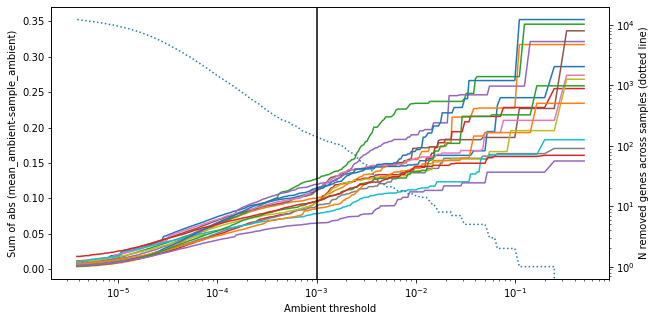

In [21]:
# Difference to average ambient scores for retained genes at each threshold
rcParams['figure.figsize']= (10,5)
fig,ax=plt.subplots()
ax2 = ax.twinx()  
for sample in adata_raw.obs.file.unique():
    ax.plot(thresholds,ambient_diffs[sample])
ax.set_xscale('log')
ax.set_ylabel('Sum of abs (mean_ambient-sample_ambient)')
ax.set_xlabel('Ambient threshold')
ax2.plot(thresholds,removed_genes['all'],linestyle='dotted')
ax2.set_yscale('log')
ax2.set_ylabel('N removed genes across samples (dotted line)')
plt.axvline(AMBIENT_THR,c='k')

In [22]:
#Retained ambient proportion per sample
#and N removed genes across samples

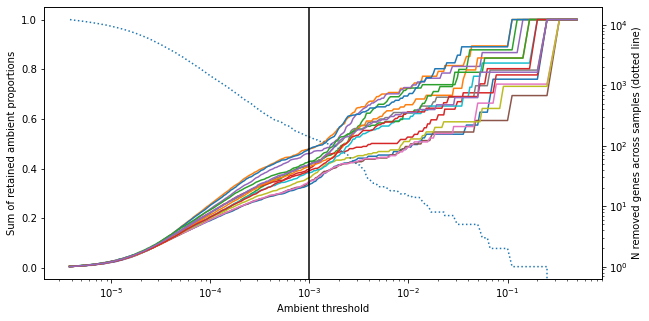

In [23]:
# Retained ambience per sample vs threshold
rcParams['figure.figsize']= (10,5)
fig,ax=plt.subplots()
for sample in adata_raw.obs.file.unique():
    ax.plot(thresholds,ambient_proportions[sample])
ax.set_xscale('log')
ax.set_ylabel('Sum of retained ambient proportions')
ax.set_xlabel('Ambient threshold')
ax2 = ax.twinx()  
ax2.plot(thresholds,removed_genes['all'],linestyle='dotted')
ax2.set_yscale('log')
ax2.set_ylabel('N removed genes across samples (dotted line)')
plt.axvline(AMBIENT_THR,c='k')

In [24]:
#N removed genes per sample

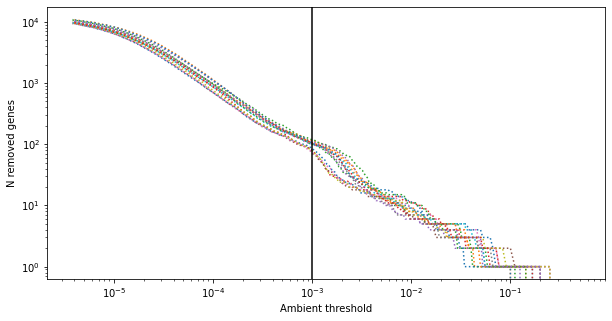

In [25]:
# N removed genes per sample
rcParams['figure.figsize']= (10,5)
fig,ax=plt.subplots()
for sample in adata_raw.obs.file.unique():
    ax.plot(thresholds,removed_genes[sample],linestyle='dotted')
ax.set_xscale('log')
ax.set_ylabel('N removed genes')
ax.set_xlabel('Ambient threshold')
ax.set_yscale('log')
plt.axvline(AMBIENT_THR,c='k')

In [ ]:
#Removed ambience proportion divided by removed genes per sample

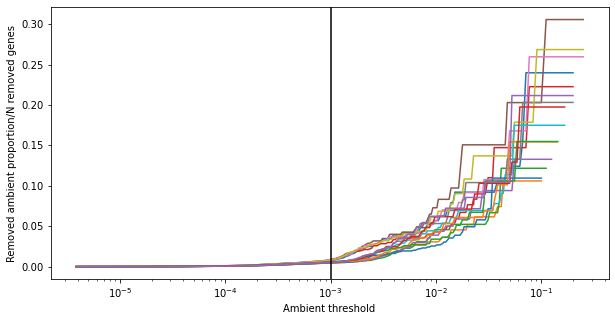

In [26]:
# Comparison of removed ambience vs N of removed genes per sample
rcParams['figure.figsize']= (10,5)
fig,ax=plt.subplots()
for sample in adata_raw.obs.file.unique():
    any_removed=np.array(removed_genes[sample])>0
    ax.plot(np.array(thresholds)[any_removed],((1-ambient_proportions[sample])/removed_genes[sample])[any_removed])
ax.set_xscale('log')
ax.set_ylabel('Removed ambient proportion/N removed genes')
ax.set_xlabel('Ambient threshold')
plt.axvline(AMBIENT_THR,c='k')

In [27]:
# Save genes with scaled mean ambient expression at least > threshold in any sample - 
# use the same genes for each sample so that further prrocessing (cell type annotation, embedding) can be done jointly
# !!! Check on heatmap that all such genes were included in the filtered 20 genes
ambient_genes_selection=list(ambient_df[(ambient_df>AMBIENT_THR).any(axis=1)].index)

print('N selected ambient genes:',len(ambient_genes_selection))
if SAVE:
    pickle.dump( ambient_genes_selection, open( shared_folder+"ambient_genes_selection_extended.pkl", "wb" ) )

N selected ambient genes: 140


In [46]:
del adata_raw

## QC (counts, genes, mt) + SPIKEIN

In [14]:
# Add other QC metrics

#adata.obs['n_counts'] = adata.X.sum(axis = 1)
#adata.obs['log_counts'] = np.log(adata.obs['n_counts'])
adata.obs['n_genes'] = (adata.X > 0).sum(axis = 1)

mt_gene_mask = np.flatnonzero([gene.startswith('mt-') for gene in adata.var_names])
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['mt_frac'] = np.sum(adata[:, mt_gene_mask].X, axis=1).A1/adata.obs['n_counts']

### QC on UMAP 
Data used for UMAP: Total count normalised data with log transformation and PC preprocessing. UMAP distances are based on correlation.

In [15]:
# Preprocess data for UMAP
adata_pp=adata.copy()
sc.pp.normalize_total(adata_pp, target_sum=1e6, exclude_highly_expressed=True)
sc.pp.log1p(adata_pp)

normalizing counts per cell The following highly-expressed genes are not considered during normalization factor computation:
['Gcg', 'B2m', 'Cst3', 'Slpi', 'Tmsb4x', 'Prdx1', 'Jchain', 'Cxcl13', 'Spp1', 'Actb', 'Try4', 'Try5', 'Igkc', 'Reg1', 'Ghrl', 'Mgp', 'Iapp', 'Apoe', 'Ftl1', 'Ctsd', 'Ins2', 'Lyz2', 'Mt1', 'Ctrb1', 'Ctsb', 'Clu', 'Ccl5', 'Ppy', 'Pyy', 'Chga', 'Igha', 'Ighg2c', 'Ighg2b', 'Ighg1', 'Ighg3', 'Ighm', 'Iglc1', 'Iglc3', 'Iglc2', 'Sst', 'Hspa1a', 'Ttr', 'Cd74', 'Malat1', 'Fth1', 'Ins1', 'Pnliprp1', 'mt-Nd1', 'mt-Nd2', 'mt-Co1', 'mt-Co2', 'mt-Atp6', 'mt-Co3', 'mt-Nd4', 'mt-Cytb']
    finished (0:00:00)


computing PCA with n_comps = 15
    finished (0:01:13)


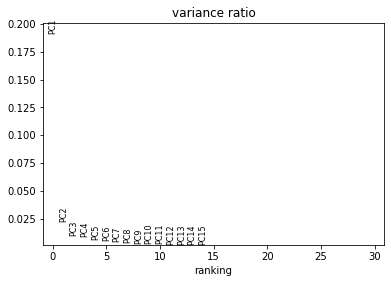

In [16]:
# Select number of PCs to use for UMAP
sc.pp.pca(adata_pp,n_comps=15,use_highly_variable =False)
sc.pl.pca_variance_ratio(adata_pp)

In [17]:
# Compute UMAP
sc.pp.neighbors(adata_pp, n_neighbors=15, n_pcs=7, metric='correlation')
sc.tl.umap(adata_pp)

computing neighbors
    using 'X_pca' with n_pcs = 7
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:27)
computing UMAP


/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/scanpy/neighbors/__init__.py:121: FutureWarning: This location for 'distances' is deprecated. It has been moved to .obsp[distances], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['distances'] = neighbors.distances
/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/scanpy/neighbors/__init__.py:122: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'] = neighbors.connectivities
/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/scanpy/tools/_umap.py:147: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'

    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:56)


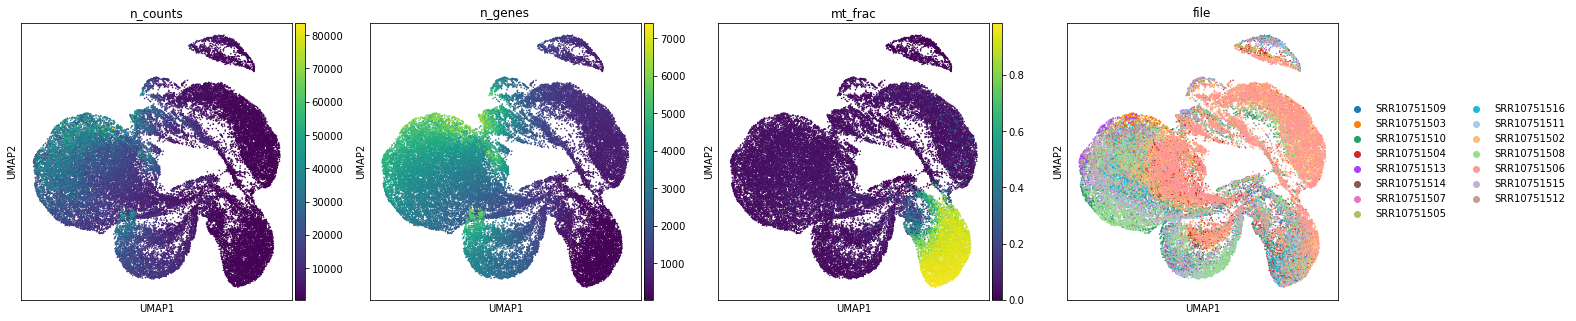

In [18]:
# Plot UMAP
rcParams['figure.figsize']=(5,5)
sc.pl.umap(adata_pp, color=['n_counts','n_genes','mt_frac','file'],size=10)

#C: There is an evident high mt fraction subpopulation.

### Remove spike in cell clusters

In [19]:
# Add previously generated annotation 
#adata_preannotated=h.open_h5ad("/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/salinno_project/rev4/maren/data_endo_final.h5ad",unique_id2=UID2)
preannotated=pd.read_table("/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/GSE142465/preannotated/GSE142465_MouseLTI_CellAnnotation_final.tsv",index_col=0)

In [20]:
preannotated.columns

Index(['nGene', 'nUMI', 'orig.ident', 'sample', 'percent.mito', 'res.0.5',
       'ClusterNames_0.5', 'tSNE_1', 'tSNE_2', 'celltype', 'spikeIn',
       'replicate', 'treatment', 'PredictedCell', 'PredictionConf',
       'PredictionMax', 'celltype2', 'nGene.peak', 'nGene.doublet', 'Ins2',
       'Gcg'],
      dtype='object')

In [21]:
preannotated.iloc[0,:]

nGene                         2866
nUMI                         16716
orig.ident                       X
sample              mIslets_I_DMSO
percent.mito             0.0261633
res.0.5                          0
ClusterNames_0.5                 0
tSNE_1                    -5.62799
tSNE_2                     11.7134
celltype                      Beta
spikeIn                        NaN
replicate                        I
treatment                     DMSO
PredictedCell                 Beta
PredictionConf             189.974
PredictionMax             0.981856
celltype2                     Beta
nGene.peak                 2746.14
nGene.doublet                 Keep
Ins2                       12.8198
Gcg                              0
Name: AAACCTGAGAAAGTGG-3, dtype: object

In [22]:
# Load metadata for the project
sample_dict=pd.read_excel('/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/scRNA-seq_pancreas_metadata.xlsx',
             sheet_name='spikein_drug',index_col='metadata')['sample_name'].to_dict()

In [23]:
# Reindex previous info df
preannotated.index=[idx.split('-')[0]+'-1-'+sample_dict[preannotated.at[idx,'sample']] for idx in preannotated.index]
preannotated=preannotated.reindex( adata_pp.obs.index)

In [24]:
# Add pre-prepared cell type annotation to currently used dataset
# Add 'pre_' before each original annotation
for annotation in ['celltype','PredictedCell','celltype2']:
    annotation_new='pre_'+annotation
    # Data was sorted before - remove index as they do not match
    adata_pp.obs[annotation_new]=pd.Series(preannotated[annotation].values,dtype='category').values
    # Replace np.nan with na
    adata_pp.obs[annotation_new] = adata_pp.obs[annotation_new].cat.add_categories('NA')
    adata_pp.obs[annotation_new].fillna('NA', inplace =True) 
    # Remove unused categories
    adata_pp.obs[annotation_new].cat.remove_unused_categories(inplace=True)

Pre-annotated cell type count

In [25]:
# Count of cells per annotation
for annotation in ['celltype','PredictedCell','celltype2']:
    # For some reason the same line above does not remove all categories, thus it is done here again
    adata_pp.obs['pre_'+annotation].cat.remove_unused_categories(inplace=True)
    print('pre_'+annotation,':')
    print(adata_pp.obs['pre_'+annotation].value_counts())

pre_celltype :
Beta            14832
NA               6278
3                3605
Alpha            3460
4                3380
Endocrine        2768
Gamma            1469
SI_Human         1093
Acinar            801
Endothelial1      787
10                769
Delta             635
11                356
Endothelial2      353
13                336
SI_Mouse          327
Name: pre_celltype, dtype: int64
pre_PredictedCell :
Beta      18995
NA         6278
Alpha      4795
Delta      3462
Gamma      2892
Acinar     2802
11         2025
Name: pre_PredictedCell, dtype: int64
pre_celltype2 :
Beta            16076
NA               6278
Alpha            3931
3                3605
4                3380
Gamma            2284
SI_Human         1093
Acinar            854
Delta             791
Endothelial1      787
10                769
11                385
Endothelial2      353
13                336
SI_Mouse          327
Name: pre_celltype2, dtype: int64


In [26]:
# Set one annotation column to pre_cell_type to enable below code to work
adata_pp.obs.rename(columns={'pre_celltype':'pre_cell_type'}, inplace=True)

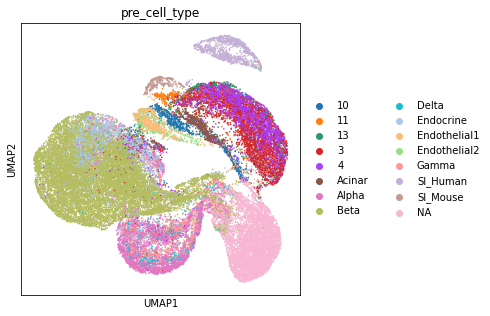

In [27]:
sc.pl.umap(adata_pp, color='pre_cell_type',size=10)

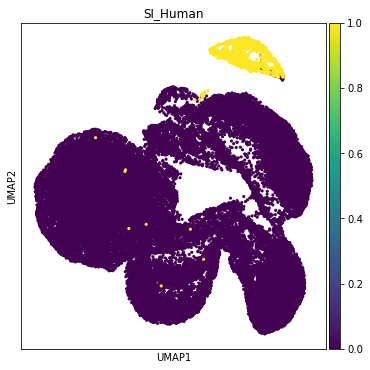

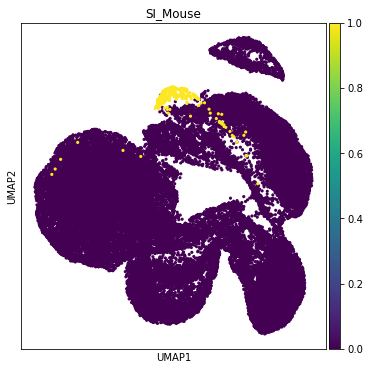

In [44]:
for si in ['SI_Human','SI_Mouse']:
    s=40
    adata_pp.obs['temp']=adata_pp.obs['pre_cell_type']==si
    sc.pl.umap(adata_pp,color='temp',size=40,title=si)
adata_pp.obs.drop('temp',axis=1,inplace=True)

In [28]:
res=0.3
sc.tl.leiden(adata_pp, resolution=res, key_added='leiden', directed=True, use_weights=True)

running Leiden clustering


/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/scanpy/tools/_leiden.py:111: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adjacency = adata.uns['neighbors']['connectivities']


    finished: found 15 clusters and added
    'leiden_scaled_r0.3', the cluster labels (adata.obs, categorical) (0:00:22)


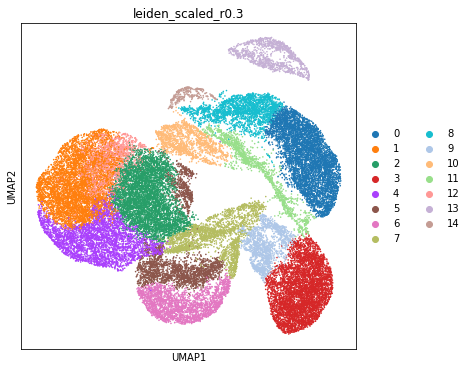

In [29]:
rcParams['figure.figsize']=(6,6)
sc.pl.umap(adata_pp, color=['leiden'] ,size=10, use_raw=False)

In [43]:
for cluster in adata_pp.obs['leiden'].unique():
    cluster_data=adata_pp.obs.query('leiden == @cluster')
    cluster_anno_n=cluster_data.pre_cell_type.value_counts(normalize=True)
    print('Cluster %s: human SI pratio %.2e, mouse SI ratio %.2e' %
          (cluster,cluster_anno_n.loc['SI_Human'],cluster_anno_n.loc['SI_Mouse']))

Cluster 5: human SI pratio 0.00e+00, mouse SI ratio 0.00e+00
Cluster 3: human SI pratio 0.00e+00, mouse SI ratio 0.00e+00
Cluster 13: human SI pratio 9.63e-01, mouse SI ratio 0.00e+00
Cluster 4: human SI pratio 0.00e+00, mouse SI ratio 0.00e+00
Cluster 7: human SI pratio 8.54e-04, mouse SI ratio 0.00e+00
Cluster 10: human SI pratio 0.00e+00, mouse SI ratio 0.00e+00
Cluster 6: human SI pratio 4.06e-04, mouse SI ratio 0.00e+00
Cluster 1: human SI pratio 1.90e-04, mouse SI ratio 7.59e-04
Cluster 9: human SI pratio 0.00e+00, mouse SI ratio 0.00e+00
Cluster 2: human SI pratio 7.65e-04, mouse SI ratio 1.91e-04
Cluster 12: human SI pratio 0.00e+00, mouse SI ratio 7.85e-04
Cluster 14: human SI pratio 0.00e+00, mouse SI ratio 9.93e-01
Cluster 11: human SI pratio 0.00e+00, mouse SI ratio 7.62e-04
Cluster 0: human SI pratio 0.00e+00, mouse SI ratio 3.76e-04
Cluster 8: human SI pratio 5.27e-03, mouse SI ratio 1.36e-02


#C: Spike-ins are in clusters 13 and 14 and some other clusters. As this clustering does not seem to resolve spike ins well they will be removed latter.

### QC - select thresholds

Check:
- joint distribution of N genes, N counts, and mt fraction
- distribution of metrics across samples

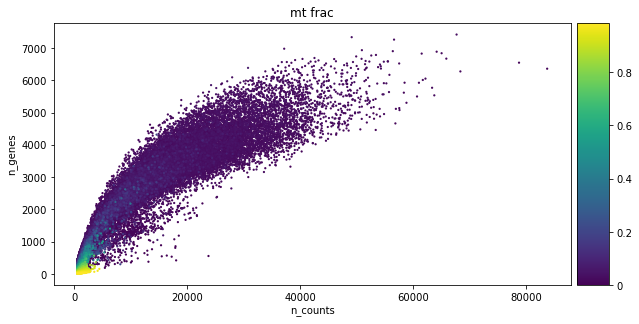

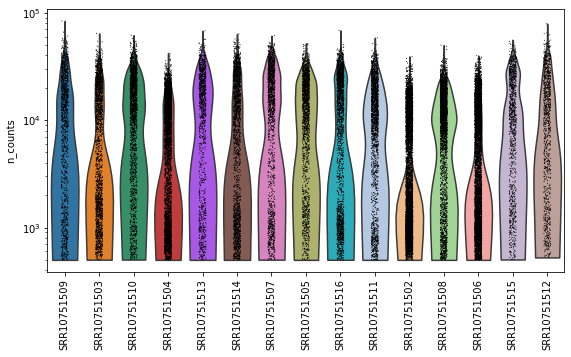

In [21]:
#Data quality summary plots
rcParams['figure.figsize']=(8,5)
p1 = sc.pl.scatter(adata, 'n_counts', 'n_genes', color='mt_frac', size=20)
sc.pl.violin(adata, ['n_counts'], groupby='file', size=1, log=True,rotation=90)
sc.pl.violin(adata, ['n_genes'], groupby='file', size=1, log=False,rotation=90)
sc.pl.violin(adata, ['mt_frac'], groupby='file', size=1, log=False,rotation=90)

#C: There are two samples with low n genes and n counts (but not high mt fraction).

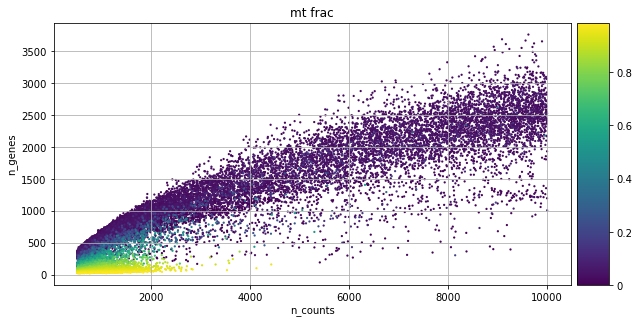

In [22]:
p1 = sc.pl.scatter(adata[np.logical_and(adata.obs['n_genes']<4000, adata.obs['n_counts']<10000)], 'n_counts', 'n_genes', color='mt_frac', size=20,show=False)
p1.grid()
plt.show()

N counts:

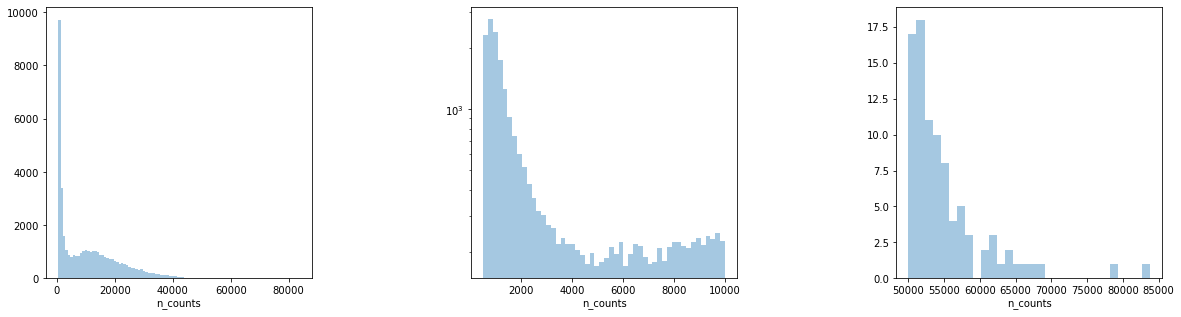

In [23]:
rcParams['figure.figsize']=(20,5)
fig_ind=np.arange(131, 134)
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.6)

p3 = sb.distplot(adata.obs['n_counts'], 
                 kde=False, 
                 ax=fig.add_subplot(fig_ind[0]), bins=100)
#p3.set_xscale('log')
p4 = sb.distplot(adata.obs['n_counts'][adata.obs['n_counts']<10000], 
                 kde=False, bins=50, 
                 ax=fig.add_subplot(fig_ind[1]))
p4.set_yscale('log')
p5 = sb.distplot(adata.obs['n_counts'][adata.obs['n_counts']>50000], 
                 kde=False, bins=30, 
                 ax=fig.add_subplot(fig_ind[2]))
plt.show()

N genes:

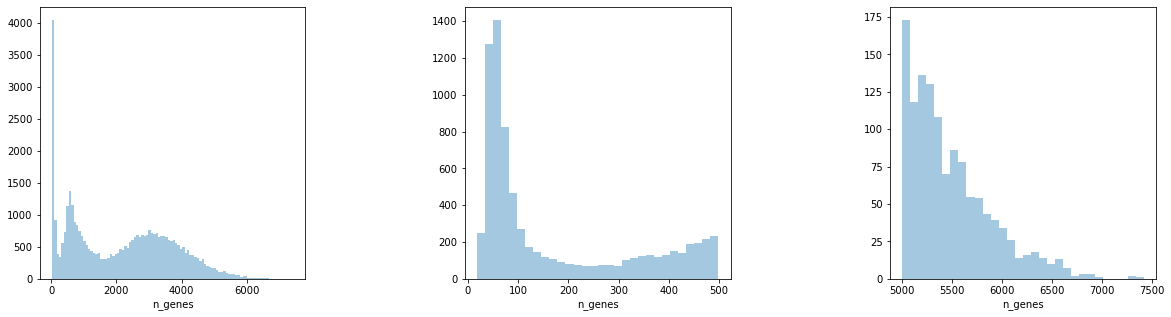

In [24]:
rcParams['figure.figsize']=(20,5)
fig_ind=np.arange(131, 134)
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.6) #create a grid for subplots

p6 = sb.distplot(adata.obs['n_genes'], kde=False, bins=100, ax=fig.add_subplot(fig_ind[0]))

p7 = sb.distplot(adata.obs['n_genes'][adata.obs['n_genes']<500], 
                 kde=False, bins=30, ax=fig.add_subplot(fig_ind[1]))
p8 = sb.distplot(adata.obs['n_genes'][adata.obs['n_genes']>5000], 
                 kde=False, bins=30, ax=fig.add_subplot(fig_ind[2]))
plt.show()

MT fraction:

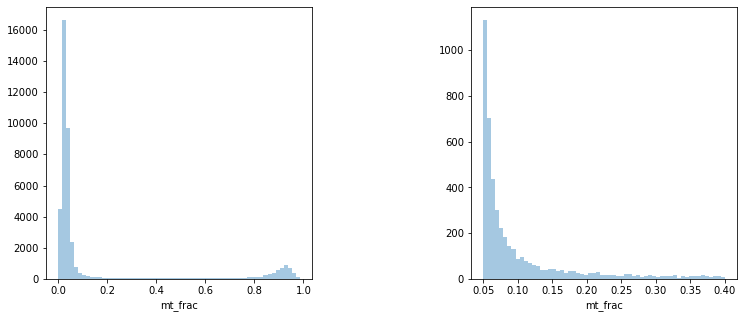

In [25]:
rcParams['figure.figsize']=(20,5)
fig_ind=np.arange(131, 133)
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.6)

p8 = sb.distplot(adata.obs['mt_frac'], kde=False, bins=60, ax=fig.add_subplot(fig_ind[0]))

p9 = sb.distplot(adata.obs['mt_frac'][adata.obs['mt_frac'].between(0.05, 0.4)], 
                 kde=False, bins=60, ax=fig.add_subplot(fig_ind[1]))
plt.show()

For cells that have too low/high metrics show location on UMAP.

In [26]:
def assign_high_low(adata,obs_col,low,high):
    """
    Add low/high annotation to each cell for a metric. 
    Add obs column specifying if cell has ok/low/high value (categories ordered in this order) and uns color map - 
    gray for ok, blue for low, red for high.
    New obs columns is named obs_col_filter and colourmap is named obs_col_filter_colors.
    :param adata: anndata object that contains column with metric to be filtered and to which filter result column
    and colur map are added
    :param obs_col: obs column on which to perform filtering
    :param low: low - cells that have obs_col value < low are assigned 'low'
    :param high: high - cells that have obs_col value > high are assigned 'high'
    """
    cell_type=[]
    for val in adata.obs[obs_col]:
        if val>high:
            cell_type.append('high')
        elif val<low:
            cell_type.append('low')
        else:
            cell_type.append('ok')
    adata.obs[obs_col+'_filter']=cell_type
    adata.obs[obs_col+'_filter']=adata.obs[obs_col+'_filter'].astype('category')
    # So that low and high are plotted on top
    adata.obs[obs_col+'_filter'].cat.reorder_categories(
        [category for category in ['ok','low','high'] if category in adata.obs[obs_col+'_filter'].cat.categories], inplace=True)
    type_col={'high':'#e62e0e','low':'#02c6ed','ok':'#a8a8a8'}
    col_list=[]
    for filter_type in adata.obs[obs_col+'_filter'].cat.categories:
        col_list.append(type_col[filter_type])
    adata.uns[obs_col+'_filter_colors']=col_list

ok      24297
low     16950
high        2
Name: n_counts_filter, dtype: int64


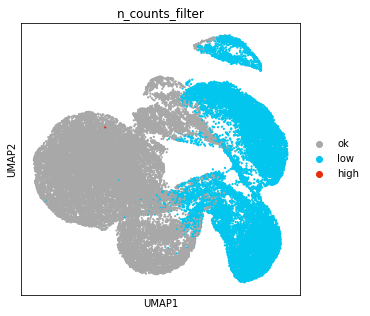

In [27]:
param='n_counts'
rcParams['figure.figsize']=(5,5)
COUNTS_THR_MIN=5000
COUNTS_THR_MAX=70000
assign_high_low(adata=adata,obs_col=param,low=COUNTS_THR_MIN,high=COUNTS_THR_MAX)
print(adata.obs[param+'_filter'].value_counts())
adata_pp.obs[param+'_filter']=adata.obs[param+'_filter']
adata_pp.uns[param+'_filter_colors']=adata.uns[param+'_filter_colors']
sc.pl.umap(adata_pp, color=[param+'_filter'],size=20)

ok      35861
low      5385
high        3
Name: n_genes_filter, dtype: int64


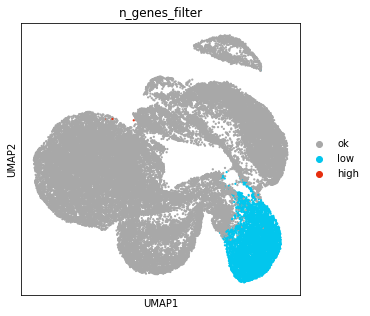

In [28]:
param='n_genes'
rcParams['figure.figsize']=(5,5)
GENES_THR_MIN=250
GENES_THR_MAX=7000
assign_high_low(adata=adata,obs_col=param,low=GENES_THR_MIN,high=GENES_THR_MAX)
print(adata.obs[param+'_filter'].value_counts())
adata_pp.obs[param+'_filter']=adata.obs[param+'_filter']
adata_pp.uns[param+'_filter_colors']=adata.uns[param+'_filter_colors']
sc.pl.umap(adata_pp, color=[param+'_filter'],size=20)

ok      35118
high     6131
Name: mt_frac_filter, dtype: int64


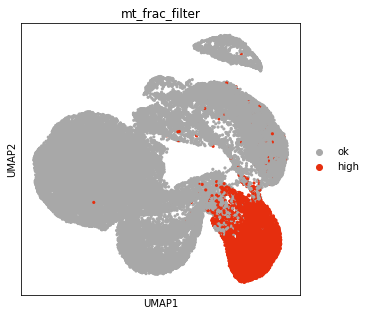

In [29]:
param='mt_frac'
MT_THR=0.2
rcParams['figure.figsize']=(5,5)
assign_high_low(adata=adata,obs_col=param,low=-1,high=MT_THR)
print(adata.obs[param+'_filter'].value_counts())
adata_pp.obs[param+'_filter']=adata.obs[param+'_filter']
adata_pp.uns[param+'_filter_colors']=adata.uns[param+'_filter_colors']
sc.pl.umap(adata_pp, color=[param+'_filter'],size=40)

#C: High n_counts will be filtered but high n_genes will not be as they seem to be closer to major population. Low n_counts will not be filtered as too many cells with otherwise ok metrics would be removed.

N cells in which a gene is expressed:

In [30]:
adata.var['n_cells']=(adata.X > 0).sum(axis = 0).T

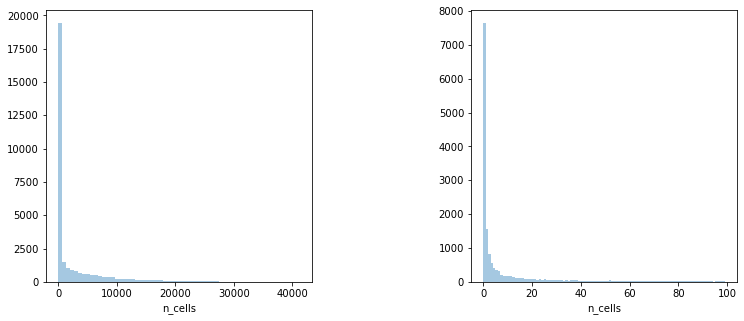

<AxesSubplot:xlabel='n_cells'>

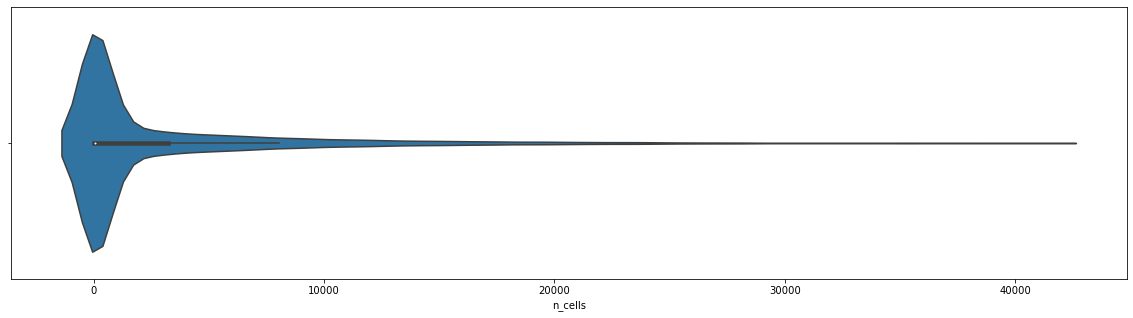

In [31]:
rcParams['figure.figsize']=(20,5)
fig_ind=np.arange(131, 133)
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.6) #create a grid for subplots

p6 = sb.distplot(adata.var['n_cells'], kde=False, bins=60, ax=fig.add_subplot(fig_ind[0]))

p8 = sb.distplot(adata.var['n_cells'][adata.var['n_cells']<100], 
                 kde=False, bins=100, ax=fig.add_subplot(fig_ind[1]))
plt.show()
sb.violinplot(adata.var['n_cells'] )

Filter out genes and cells

In [32]:
# Filter cells according to identified QC thresholds:
print('Total number of cells: {:d}'.format(adata.n_obs))


sc.pp.filter_cells(adata, max_counts = COUNTS_THR_MAX)
print('Number of cells after max count filter: {:d}'.format(adata.n_obs))

adata = adata[adata.obs['mt_frac'] <= MT_THR]
print('Number of cells after MT filter: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_genes = GENES_THR_MIN)
print('Number of cells after min gene filter: {:d}'.format(adata.n_obs))

Total number of cells: 41249
filtered out 2 cells that have more than 70000 counts
Number of cells after max count filter: 41247
Number of cells after MT filter: 35116
filtered out 85 cells that have less than 250 genes expressed


Trying to set attribute `.obs` of view, copying.


Number of cells after min gene filter: 35031


In [33]:
#Filter genes:
print('Total number of genes: {:d}'.format(adata.n_vars))

CELLS_THR_MIN=20
# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata, min_cells=CELLS_THR_MIN)
print('Number of genes after cell filter: {:d}'.format(adata.n_vars))

Total number of genes: 31257
filtered out 13527 genes that are detected in less than 20 cells
Number of genes after cell filter: 17730


Subset genes so that ref genes are not removed - UNUSED - insetad of the above cell

## Doublet filtering

Perform doublet filtering with Scrublet per sample.

In [34]:
adata.obs['doublet_score']=np.zeros(adata.shape[0])
adata.obs['doublet']=np.zeros(adata.shape[0])

# filtering/preprocessing parameters:
min_counts = 3
min_cells = 3
vscore_percentile = 85
n_pc = 30

# doublet detector parameters:
expected_doublet_rate = 0.05 
sim_doublet_ratio = 2
n_neighbors = None #If `None`, this is set to round(0.5 * sqrt(n_cells))

# Detect doublets per sample
for batch in adata.obs['file'].cat.categories:
    idx = adata.obs[adata.obs['file']==batch].index
    print(batch, 'N cells:',idx.shape[0])
    scrub = scr.Scrublet(counts_matrix = adata[idx,:].X,  
                     n_neighbors = n_neighbors,
                     sim_doublet_ratio = sim_doublet_ratio,
                     expected_doublet_rate = expected_doublet_rate)
    doublet_scores, predicted_doublets = scrub.scrub_doublets( 
                    min_counts = min_counts, 
                    min_cells = min_cells, 
                    n_prin_comps = n_pc,
                    use_approx_neighbors = True, 
                    get_doublet_neighbor_parents = False)
    adata.obs.loc[idx,'doublet_score'] = doublet_scores
    adata.obs.loc[idx,'doublet'] = predicted_doublets

SRR10751509 N cells: 1145
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.35
Detected doublet rate = 0.3%
Estimated detectable doublet fraction = 18.8%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 1.4%
Elapsed time: 2.0 seconds
SRR10751503 N cells: 2020
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.41
Detected doublet rate = 0.3%
Estimated detectable doublet fraction = 19.3%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 1.8%
Elapsed time: 2.2 seconds
SRR10751510 N cells: 2032
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.43
Detected doublet rate = 0.4%
Estimated detectable doublet fraction = 8.8%
Overall doublet rate:
	Expected   = 5.0%
	Esti

Distribution of doublet scores

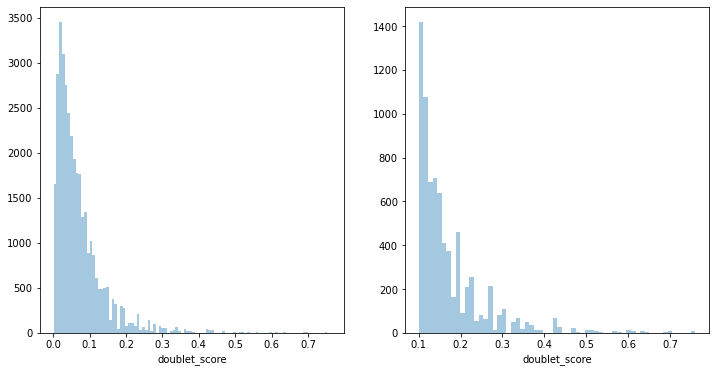

... storing 'doublet' as categorical


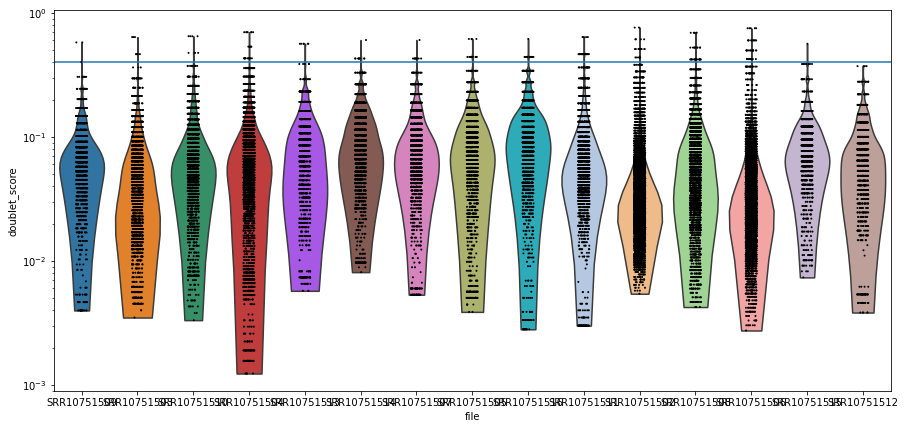

In [35]:
rcParams['figure.figsize']=(12,6)
fig,ax=plt.subplots(1,2)
sb.distplot(adata.obs['doublet_score'], bins=100, kde=False,ax=ax[0])
sb.distplot(adata[adata.obs.doublet_score>0.1].obs['doublet_score'], bins=60, kde=False,ax=ax[1])
plt.show()

rcParams['figure.figsize']=(15,7)
fig,ax=plt.subplots()
sc.pl.violin(adata, 'doublet_score',
                  groupby='file',
                  size=2, log=True, cut=0,ax=ax,show=False)
DOUBLET_THR=0.4
ax.axhline(DOUBLET_THR)
plt.show()

Trying to set attribute `.obs` of view, copying.


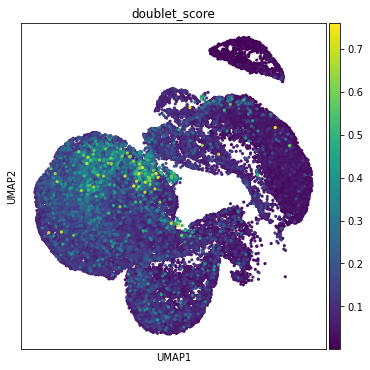

ok      34807
high      224
Name: doublet_score_filter, dtype: int64


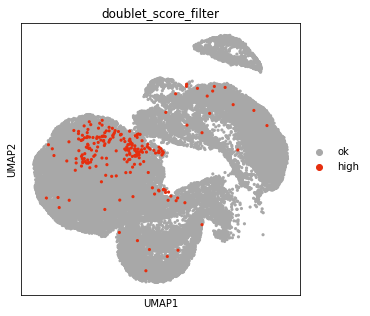

In [36]:
# Remove cells from adata_pp that were removed before from adata
adata_pp=adata_pp[adata.obs.index]

# Plot doublet score and filtering threshold on UMAP
rcParams['figure.figsize']=(6,6)
adata_pp.obs['doublet_score']=adata.obs['doublet_score']
sc.pl.umap(adata_pp, color=['doublet_score'],size=40)
param='doublet_score'
rcParams['figure.figsize']=(5,5)
assign_high_low(adata=adata,obs_col=param,low=-np.inf,high=DOUBLET_THR)
print(adata.obs[param+'_filter'].value_counts())
adata_pp.obs[param+'_filter']=adata.obs[param+'_filter']
adata_pp.uns[param+'_filter_colors']=adata.uns[param+'_filter_colors']
sc.pl.umap(adata_pp[adata_pp.obs[param+'_filter'].sort_values().index], color=[param+'_filter'],size=40)

In [37]:
print('Number of cells before doublet filter: {:d}'.format(adata.n_obs))
idx_filt = adata.obs['doublet_score']<=DOUBLET_THR

adata = adata[idx_filt].copy()
print('Number of cells after doublet filter: {:d}'.format(adata.n_obs))

Number of cells before doublet filter: 35031
Number of cells after doublet filter: 34807


## Summary after QC

In [38]:
# Summary statistics per file/batch
df = adata.obs[['n_genes','n_counts','file']]
df_all = pd.DataFrame(index=df['file'].unique())

df_all['mean_genes']=df.groupby(by='file')['n_genes'].mean()
df_all['median_genes']=df.groupby(by='file')['n_genes'].median()
df_all['mean_counts']=df.groupby(by='file')['n_counts'].mean()
df_all['median_counts']=df.groupby(by='file')['n_counts'].median()
df_all['n_cells']=df['file'].value_counts()
df_all.astype('float').round(1)

mean_genes  median_genes  mean_counts  median_counts  n_cells
SRR10751509      2747.5        2948.0      17593.2        15726.5   1142.0
SRR10751503      2934.9        3075.0      13549.8        12198.0   2013.0
SRR10751510      3021.3        3185.0      17582.5        16819.0   2024.0
SRR10751504      2409.5        2559.5      10779.2        10282.0   3428.0
SRR10751513      3658.1        3925.0      19404.8        18764.0    997.0
SRR10751514      2945.6        3073.0      17957.6        16507.5   1502.0
SRR10751507      3292.4        3360.0      21479.9        20826.0   1395.0
SRR10751505      3240.0        3456.0      17125.6        16486.5   1654.0
SRR10751516      3103.5        3259.0      19151.3        19179.0   1641.0
SRR10751511      2898.7        2905.0      15424.0        14172.0   1977.0
SRR10751502      1674.6        1080.0       5956.5         2392.0   6301.0
SRR10751508      2655.3        2722.0      12450.6        11764.5   3142.0
SRR10751506      1880.1        1481.0       7793.7         5052.0   5753.0
SRR10751515      3050.7        3215.5      18522.2        16615.0    968.0
SRR10751512      3056.4        3168.5      17766.5        15358.0    870.0

#C: Two samples had low n_counts but after other filters they have comparable N cells to other samples and will thus be retained. 

In [39]:
# Check that all filters were used properly - the min/max values are as expected
print('N counts range:',round(adata.obs['n_counts'].min(),1),'-',round(adata.obs['n_counts'].max(),1))
print('N genes range:',adata.obs['n_genes'].min(),'-',adata.obs['n_genes'].max())
print('Mt fraction range:',"{:.3e}".format(adata.obs['mt_frac'].min()),'-',"{:.3e}".format(adata.obs['mt_frac'].max()))
print('Doublet score range:',"{:.3e}".format(adata.obs['doublet_score'].min()),'-',"{:.3e}".format(adata.obs['doublet_score'].max()))
print('N cellls expressing a gene range:',adata.var['n_cells'].min(),'-',adata.var['n_cells'].max())

N counts range: 500.0 - 68402.0
N genes range: 250 - 7416
Mt fraction range: 0.000e+00 - 1.993e-01
Doublet score range: 1.237e-03 - 3.871e-01
N cellls expressing a gene range: 20 - 35024


## Save QC data

In [40]:
# Save QC data
if SAVE:
    #adata.write(shared_folder+'data_QC.h5ad')
    h.save_h5ad(adata=adata,file=shared_folder+'data_QC.h5ad',unique_id2=UID2)
    #pickle.dump( adata, open( shared_folder+"data_QC.pkl", "wb" ) )

## Normalisation and log-scaling

In [41]:
# Load QC data
#adata=sc.read_h5ad(shared_folder+'data_QC.h5ad')
#adata=pickle.load( open( shared_folder+"data_QC.pkl", "rb" ) )
adata=h.open_h5ad(file=shared_folder+'data_QC.h5ad',unique_id2=UID2)

In [42]:
# Remove ambient genes from analysis - required if joint normalisation is performed
print('Number of genes: {:d}'.format(adata.var.shape[0]))
ambient_genes=pickle.load( open( shared_folder+"ambient_genes_selection.pkl", "rb" ) )
# Save all genes to raw
adata.raw=adata.copy()
adata = adata[:,np.invert(np.in1d(adata.var_names, ambient_genes))].copy()
print('Number of genes after ambient removal: {:d}'.format(adata.var.shape[0]))

Number of genes: 17730
Number of genes after ambient removal: 17709


In [43]:
adata.layers['counts'] = adata.X.copy()

In [44]:
# Data for: clustering for scran normalization in clusters and visualisation of samples on UMAP
# Make new adata_pp object that also has removed unexpressed genes 
# The adata_pp is pre-processed with normalisation to N total counts, log transformation and PC dimeni
adata_pp=adata.copy()
sc.pp.normalize_total(adata_pp, target_sum=1e6, exclude_highly_expressed=True)
sc.pp.log1p(adata_pp)
sc.pp.pca(adata_pp, n_comps=15)
sc.pp.neighbors(adata_pp)

normalizing counts per cell The following highly-expressed genes are not considered during normalization factor computation:
['Hspa5', 'B2m', 'Chgb', 'Cst3', 'Slpi', 'Pcsk1n', 'Cltrn', 'Tmsb4x', 'S100a6', 'Prdx1', 'Cd52', 'Jchain', 'Pf4', 'Cxcl2', 'Cxcl13', 'Spp1', 'Actb', 'Try4', 'Try5', 'Prss2', 'Reg1', 'Ghrl', 'Mgp', 'Apoe', 'Ctsd', 'Psap', 'Lyz2', 'Mt2', 'Mt1', 'Ctrb1', 'AC160336.1', 'Ctsb', 'Clu', 'Mmp3', 'Rplp1', 'Ubb', 'Ccl5', 'Chga', 'Meg3', 'Igha', 'Ighg2c', 'Ighg2b', 'Ighg1', 'Ighg3', 'Iglc1', 'Iglc3', 'Iglc2', 'Clps', 'Tff1', 'Hspa1a', 'Ttr', 'Cd74', 'Pnliprp1', 'mt-Nd2']
    finished (0:00:01)
computing PCA with n_comps = 15
    finished (0:00:16)
computing neighbors
    using 'X_pca' with n_pcs = 15
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:10)


/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/scanpy/neighbors/__init__.py:121: FutureWarning: This location for 'distances' is deprecated. It has been moved to .obsp[distances], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['distances'] = neighbors.distances
/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/scanpy/neighbors/__init__.py:122: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'] = neighbors.connectivities


Cluster cells for scran normalisation

In [45]:
# Perform clustering
sc.tl.leiden(adata_pp, key_added='groups', resolution=1)
print('N clusters:',adata_pp.obs['groups'].unique().shape[0])

running Leiden clustering


/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/scanpy/tools/_leiden.py:111: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adjacency = adata.uns['neighbors']['connectivities']


    finished: found 35 clusters and added
    'groups', the cluster labels (adata.obs, categorical) (0:00:15)
N clusters: 35


Compare samples on UMAP before scran normalisation to decide if it can be peroformed jointly or not.

In [46]:
# Calculate UMAP
sc.tl.umap(adata_pp)

computing UMAP


/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/scanpy/tools/_umap.py:147: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'].tocoo(),


    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:36)


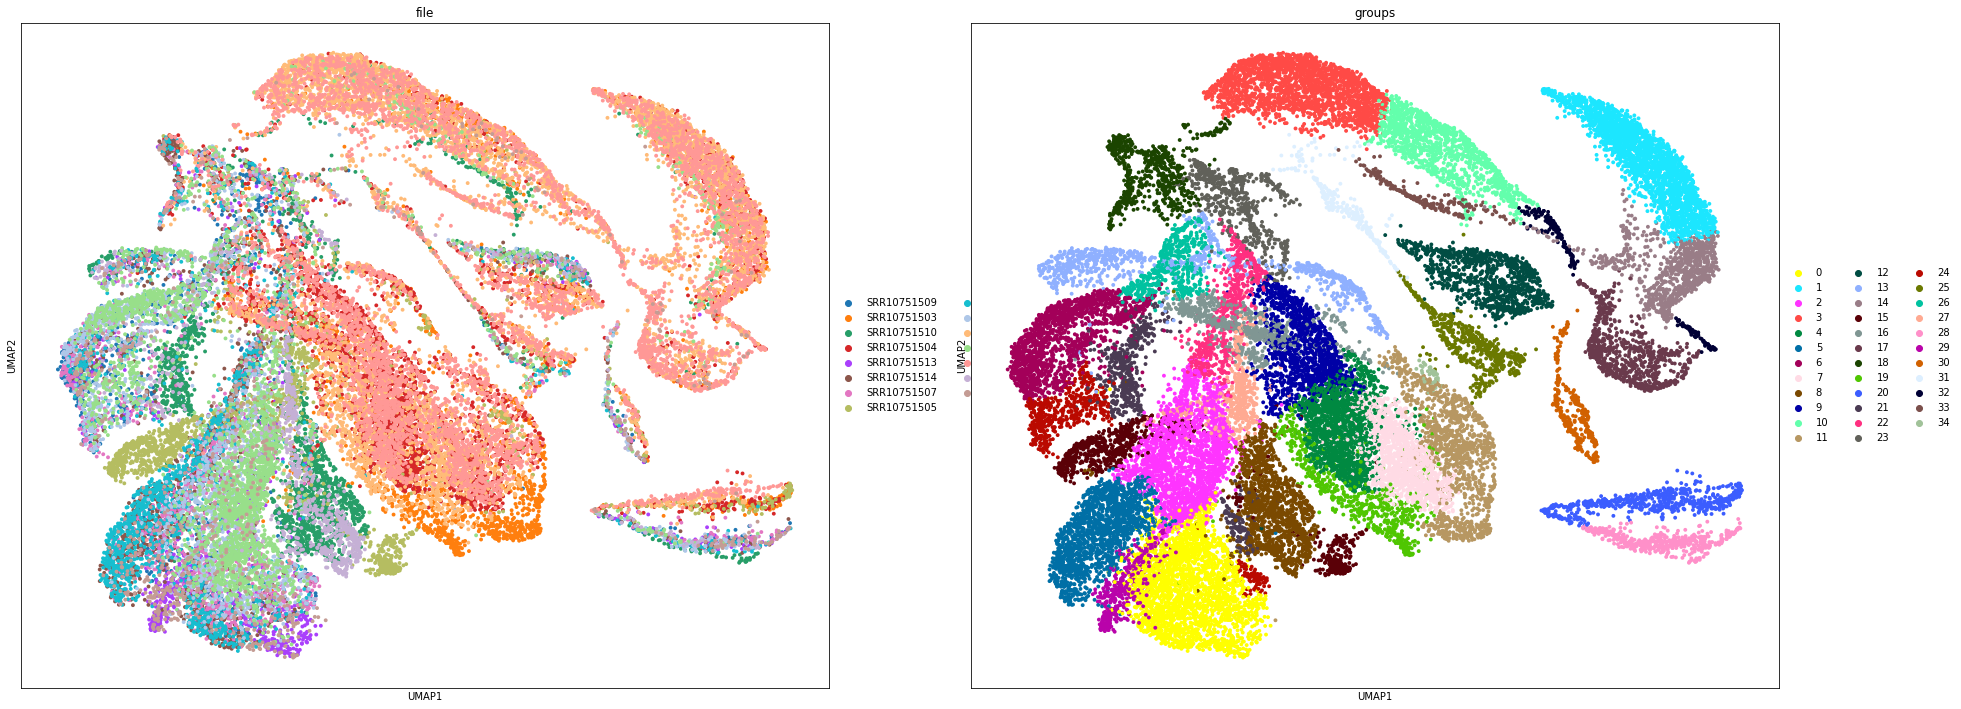

In [47]:
# Plot UMAP
rcParams['figure.figsize']=(15,12)
sc.pl.umap(adata_pp, color=['file','groups'],size=60)

Joint Scran normalisation

In [48]:
#Preprocess variables for scran normalization
input_groups = adata_pp.obs['groups']
data_mat = adata.X.T

In [49]:
%%R -i data_mat -i input_groups -o size_factors
# min.mean was increased compared to other studies not to get error in size factors (negative)
size_factors =  calculateSumFactors(data_mat, clusters=input_groups, min.mean=0.15,BPPARAM=MulticoreParam(workers = 8))

Distribution of size factors

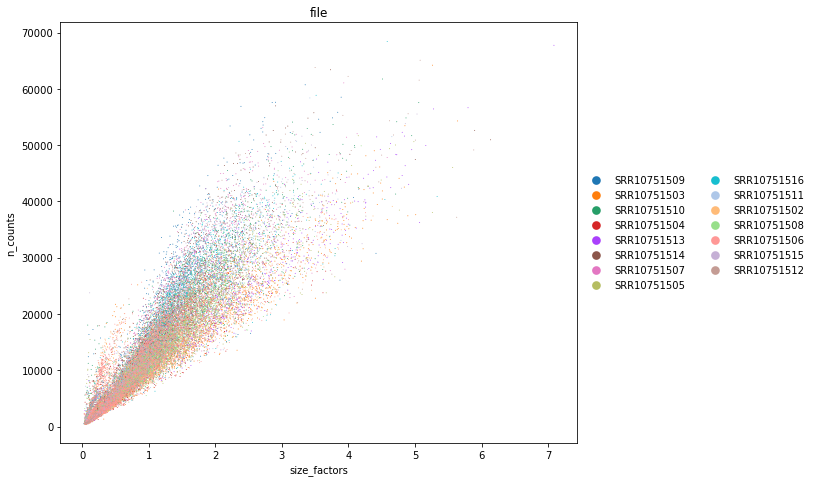

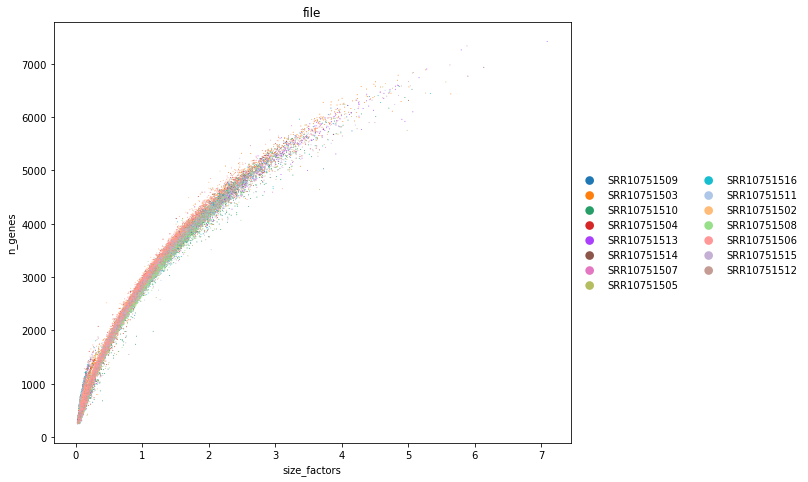

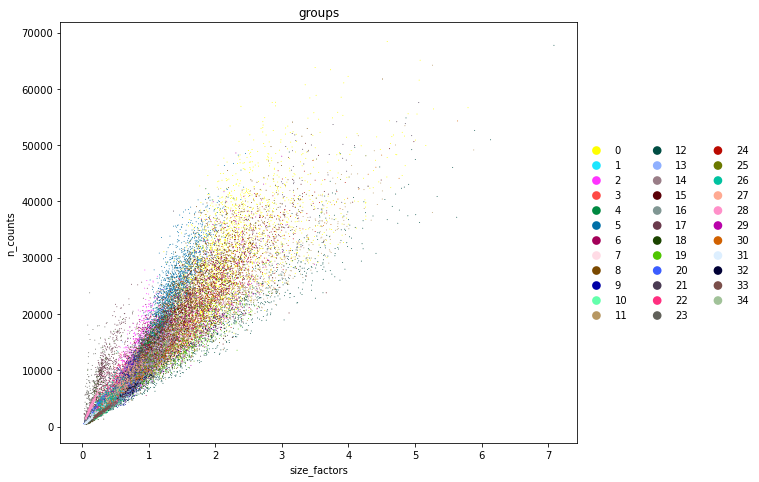

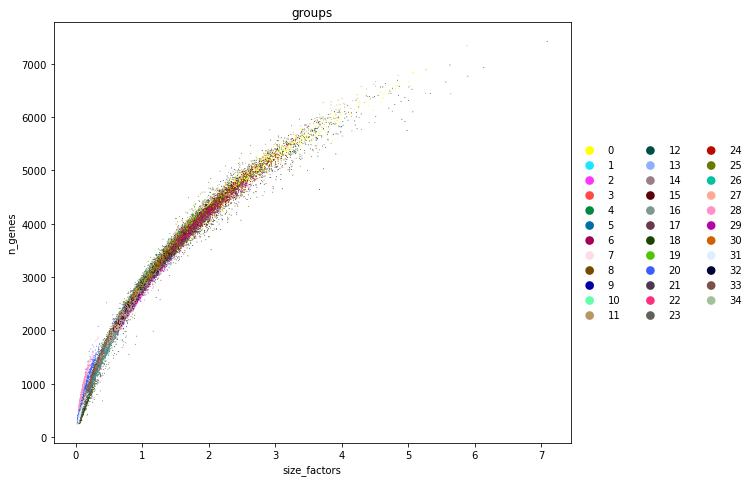

Distribution of size factors


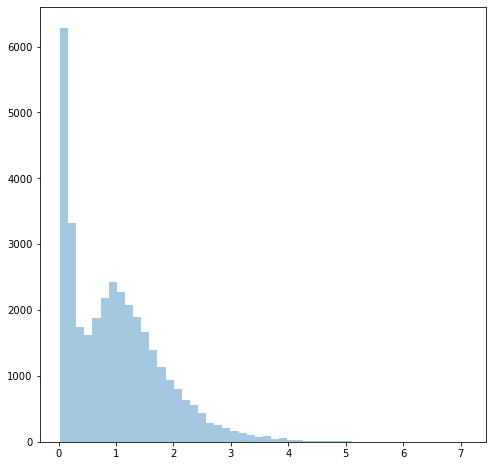

In [50]:
# Visualize the estimated size factors
adata.obs['size_factors'] = size_factors
adata_pp.obs['size_factors'] = size_factors

rcParams['figure.figsize']=(8,8)
sc.pl.scatter(adata, 'size_factors', 'n_counts', color='file')
sc.pl.scatter(adata, 'size_factors', 'n_genes', color='file')

#let us visualise how size factors differ across clusters
rcParams['figure.figsize']=(8,8)
#Use adata_pp here as it has obs 'group' - the n_genes and n_counts were copied from andata (counts/not normalised)
sc.pl.scatter(adata_pp, 'size_factors', 'n_counts', color='groups')
sc.pl.scatter(adata_pp, 'size_factors', 'n_genes', color='groups')

print('Distribution of size factors')
sb.distplot(size_factors, bins=50, kde=False)
plt.show()

In [51]:
# Scale data with size factors
adata.X /= adata.obs['size_factors'].values[:,None] # This reshapes the size-factors array
sc.pp.log1p(adata)
adata.X = np.asarray(adata.X)

In [52]:
del adata_pp

## Highly variable genes

Compare Seurat and CellRanger HVGs.

In [53]:
##hvg_vars=['highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection']

## Seurat
#sc.pp.highly_variable_genes(adata, flavor='seurat', batch_key='file')
#n_hvg_seurat=np.sum(adata.var['highly_variable'])
#print('\n','Number of highly variable genes: {:d}'.format(n_hvg_seurat))
##hvg_seurat=adata.var[hvg_vars]
#rcParams['figure.figsize']=(10,5)
#sc.pl.highly_variable_genes(adata)

## Same number of genes in CellRanger
#sc.pp.highly_variable_genes(adata, flavor='cell_ranger', batch_key='file',n_top_genes =n_hvg_seurat)
#print('\n','Number of highly variable genes: {:d}'.format(np.sum(adata.var['highly_variable'])))
##hvg_cellranger=adata.var[hvg_vars]
#rcParams['figure.figsize']=(10,5)
#sc.pl.highly_variable_genes(adata)

#C: Decided for CellRanger method.

extracting highly variable genes
    finished (0:00:18)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)

 Number of highly variable genes: 2000


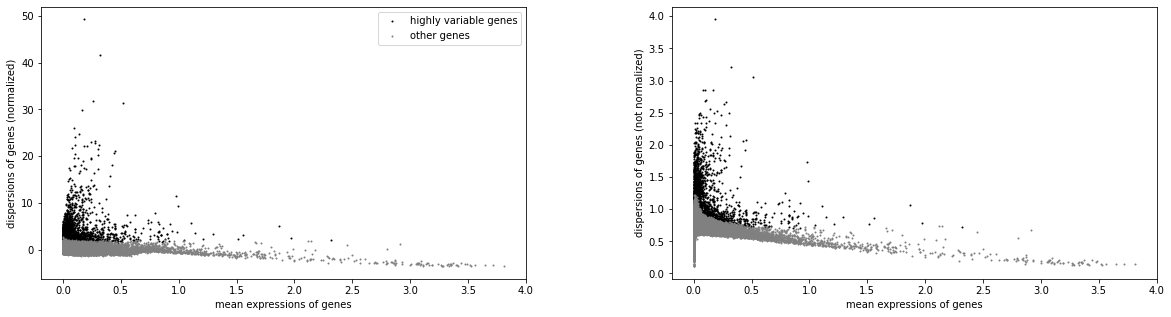

In [54]:
# Compute and plot HVG
sc.pp.highly_variable_genes(adata, flavor='cell_ranger', batch_key='file',n_top_genes =2000)
print('\n','Number of highly variable genes: {:d}'.format(np.sum(adata.var['highly_variable'])))
rcParams['figure.figsize']=(10,5)
sc.pl.highly_variable_genes(adata)

In [55]:
adata

AnnData object with n_obs × n_vars = 34807 × 17709
    obs: 'file', 'n_genes', 'n_counts', 'mt_frac', 'n_counts_filter', 'n_genes_filter', 'mt_frac_filter', 'doublet_score', 'doublet', 'doublet_score_filter', 'size_factors'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'doublet_score_filter_colors', 'file_colors', 'mt_frac_filter_colors', 'n_counts_filter_colors', 'n_genes_filter_colors', 'log1p'
    layers: 'counts'

## Save normalised data

In [56]:
# Used due to problems with saving h5ad
#pickle.dump( adata, open( shared_folder+"data_normalised.pkl", "wb" ) )

In [57]:
if SAVE:
    #adata.write(shared_folder+"data_normalised.pkl")
    h.save_h5ad(adata=adata, file=shared_folder+"data_normalised.h5ad",unique_id2=UID2)

In [20]:
#adata_temp=adata.copy()
#adata=adata_temp.copy()

In [21]:
#adata_temp.write('/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/salinno_project/rev4/scanpy_AnnData/data_processed_temp.h5ad')